In [17]:
import pandas as pd
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
#from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import IPython.display as ipd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision.models as models
from torchaudio.functional import DB_to_amplitude
import seaborn as sns

Importing augmentations

In [18]:
import augmentations

Setting config variables

In [19]:
MAX_LEN = 22000

In [20]:
df = pd.DataFrame(columns=['path', 'label', 'aug'])
# directory is bird_audio, subdirectories are the bird species, they have ogg files

# get the path of the audio files

import os
directory = 'bird_audio'
for subdir, dirs, files in os.walk(directory):
    for file in files:
        if file.endswith('.ogg'):
            path = os.path.join(subdir, file)
            label = path.split('\\')[1]
            df = df._append({'path': path, 'label': label, "aug": None}, ignore_index=True)

In [21]:
df
# aug = [None, 'time-shift' 'noise', 'rotation', 'custom1']

path    label   aug
0       bird_audio\asbfly\XC134896.ogg   asbfly  None
1       bird_audio\asbfly\XC164848.ogg   asbfly  None
2       bird_audio\asbfly\XC175797.ogg   asbfly  None
3       bird_audio\asbfly\XC207738.ogg   asbfly  None
4       bird_audio\asbfly\XC209218.ogg   asbfly  None
...                                ...      ...   ...
24454  bird_audio\zitcis1\XC845747.ogg  zitcis1  None
24455  bird_audio\zitcis1\XC845817.ogg  zitcis1  None
24456  bird_audio\zitcis1\XC856176.ogg  zitcis1  None
24457  bird_audio\zitcis1\XC856723.ogg  zitcis1  None
24458  bird_audio\zitcis1\XC858550.ogg  zitcis1  None

[24459 rows x 3 columns]

Remember to only use augmentations for train and not for test

In [22]:
df.describe()

path    label  aug
count                            24459    24459    0
unique                           24459      182    0
top     bird_audio\asbfly\XC134896.ogg  zitcis1  NaN
freq                                 1      500  NaN

In [23]:
df.groupby('label').count().sort_values('path', ascending=False)

path  aug
label             
zitcis1   500    0
lirplo    500    0
litgre1   500    0
comgre    500    0
comkin1   500    0
...       ...  ...
blaeag1     6    0
wynlau1     6    0
niwpig1     5    0
asiope1     5    0
integr      5    0

[182 rows x 2 columns]

In [24]:
torchaudio.load(df['path'][0]) # sig, sr

(tensor([[ 1.3738e-06,  9.2571e-07, -2.7169e-06,  ...,  6.2166e-06,
          -1.4831e-06, -3.4762e-06]]),
 32000)

In [25]:
torchaudio.load(df['path'][0])[0].shape

torch.Size([1, 875207])

In [26]:
def preprocessingaug(aud, sr):
    aud, sr = augmentations.repeat_pad_trunc((aud, sr), MAX_LEN)
    spectro1 = transforms.MelSpectrogram()(aud)
    spectro1 = transforms.AmplitudeToDB()(spectro1)
    #remove bottom 15 rows of the matrix
    spectro1 = spectro1[:,15:]
    spectro1 = spectro1[:,::4,::4]
    spectro1_m, spectro1_s = spectro1.mean(), spectro1.std()
    spectro1 = torch.clamp(spectro1, min=-40)
    spectro1 = (spectro1 - spectro1_m) / spectro1_s
    return spectro1, sr

In [27]:
aud, sr = torchaudio.load(r"C:\Users\Arnav\Documents\Python Scripts\audioaugbtp\bird_audio\whbwag1\XC267085.ogg")
audpad,srpad = augmentations.repeat_pad_trunc((aud,sr), MAX_LEN)
spectro = transforms.MelSpectrogram()(audpad)
spectro = transforms.AmplitudeToDB()(spectro)


c:\Users\Arnav\anaconda3\envs\torchenv\lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


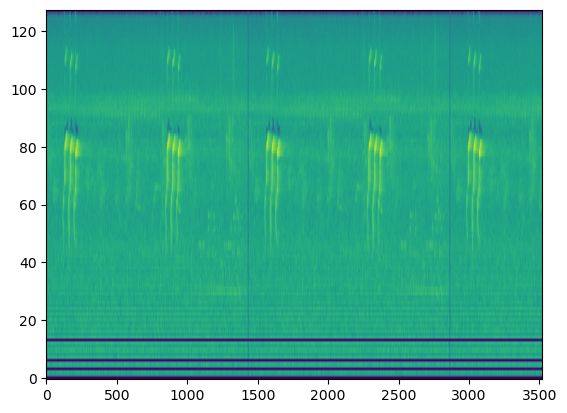

In [28]:
matrix = spectro.numpy()[0]
plt.imshow(matrix, aspect='auto', origin='lower')


In [29]:
newspectro, newsr = preprocessingaug(aud, sr)

In [30]:
newspectroshift = augmentations.time_shift_spectro(newspectro, 0.5)
newspectroshiftnoise = augmentations.add_noise_spectro(newspectroshift, 0.2)
newspectroshiftnoisespec = augmentations.specaugment(newspectroshiftnoise)

(29, 881)


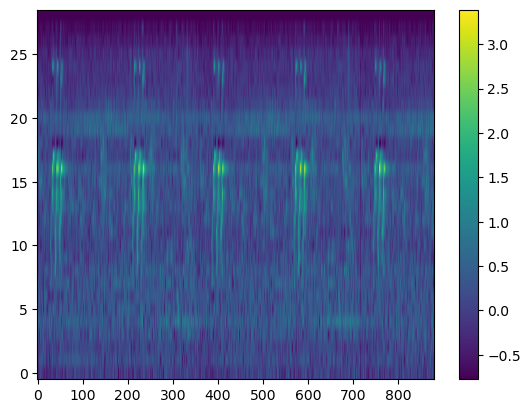

In [31]:
matrixnew = newspectro.numpy()[0]
print(matrixnew.shape)
plt.imshow(matrixnew, aspect='auto', origin='lower')
plt.colorbar()

(29, 881)


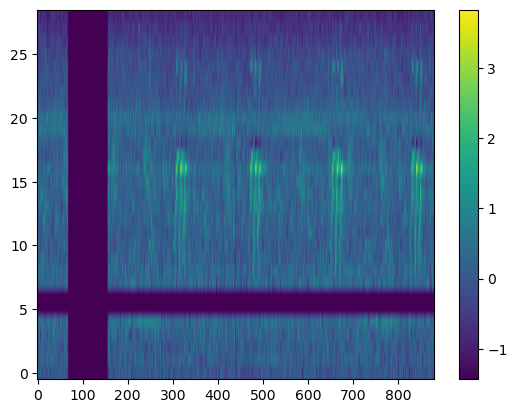

In [32]:
matrixaugmented = newspectroshiftnoisespec.numpy()[0]
print(matrixaugmented.shape)
plt.imshow(matrixaugmented, aspect='auto', origin='lower')
plt.colorbar()


In [33]:
# hear the matrix by converting back to audio
n_fft = 1024
n_stft = int((n_fft//2)+1)
audn = DB_to_amplitude(spectro, ref=1.0, power=1)
audn = transforms.InverseMelScale(n_stft=n_stft)(audn)
audn = transforms.GriffinLim(n_fft=n_fft)(audn)
audn = audn.squeeze().numpy()
ipd.Audio(audn, rate=sr)

In [34]:
class UnAugmentedTrainDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.length = df.shape[0]
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):

        path = self.df['path'][idx]
        label = self.df['label'][idx]
        #label = torch.tensor(label, dtype=torch.long)
        aud, sr = torchaudio.load(path)
        #do time domain stuff
        
        aud, sr = augmentations.repeat_pad_trunc((aud, sr), MAX_LEN)
        spectro, sr= preprocessingaug(aud, sr)
        
        

        return spectro, label

In [35]:
class AugmentedTrainDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.length = df.shape[0]
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):

        path = self.df['path'][idx]
        label = self.df['label'][idx]
        #label = torch.tensor(label, dtype=torch.long)
        aud, sr = torchaudio.load(path)
        #do time domain stuff
        spectro, sr = preprocessingaug(aud,sr)
        spectro_shifted = augmentations.time_shift_spectro(spectro, 0.2)
        #make master output tensor with just spectro and augmented spectro
        spectro_noise = augmentations.add_noise_spectro(spectro_shifted, 0.2)
        spectro_spec = augmentations.specaugment(spectro_noise)
        outputdata =  (spectro, spectro_shifted, spectro_noise, spectro_spec)

        
        

        return outputdata, label

In [36]:
class TestDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.length = df.shape[0]
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):

        path = self.df['path'][idx]
        label = self.df['label'][idx]
        label = torch.tensor(label, dtype=torch.long)
        aud, sr = torchaudio.load(path)
        #DO NOT AUGMENT, ONLY NORMALIZE (and other things like pad, trunc if needed)
        #do time domain stuff
        aud, sr = augmentations.repeat_pad_trunc((aud, sr), MAX_LEN)
        

        spectro = transforms.MelSpectrogram()(aud)
        spectro = transforms.AmplitudeToDB()(spectro)
        spectro = spectro[:, 15:]
        spectro_m, spectro_s = spectro.mean(), spectro.std()
        spectro = torch.clamp(spectro, min=-40)
        spectro = (spectro - spectro_m) / spectro_s

        spectro = spectro[::2]

        
        
        #do frequency domain stuff
        

        return spectro, label

In [37]:
model_df = df[df["label"].isin(['lirplo', "litgre1"])]
labels = model_df['label'].unique()
label_map = {label: i for i, label in enumerate(labels)}
model_df["label"] = model_df["label"].map(label_map)

C:\Users\Arnav\AppData\Local\Temp\ipykernel_13604\2636743415.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df["label"] = model_df["label"].map(label_map)


In [38]:
model_df["label"].value_counts()

label
0    500
1    500
Name: count, dtype: int64

In [39]:
# equalize the number of samples in the labels of the model_df
min_samples = model_df["label"].value_counts().min()
model_df = model_df.groupby("label").apply(lambda x: x.sample(min_samples)).reset_index(drop=True)

C:\Users\Arnav\AppData\Local\Temp\ipykernel_13604\800467558.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  model_df = model_df.groupby("label").apply(lambda x: x.sample(min_samples)).reset_index(drop=True)


In [40]:
model_df["label"].value_counts()

label
0    500
1    500
Name: count, dtype: int64

In [41]:
model_df

path  label   aug
0     bird_audio\lirplo\XC736830.ogg      0  None
1     bird_audio\lirplo\XC701914.ogg      0  None
2     bird_audio\lirplo\XC544370.ogg      0  None
3     bird_audio\lirplo\XC738521.ogg      0  None
4     bird_audio\lirplo\XC576991.ogg      0  None
..                               ...    ...   ...
995  bird_audio\litgre1\XC554664.ogg      1  None
996  bird_audio\litgre1\XC424678.ogg      1  None
997  bird_audio\litgre1\XC567962.ogg      1  None
998  bird_audio\litgre1\XC842327.ogg      1  None
999  bird_audio\litgre1\XC376676.ogg      1  None

[1000 rows x 3 columns]

In [42]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(model_df, test_size=0.3)

train_dataset = AugmentedTrainDataset(train_df.reset_index(drop=True))
test_dataset = AugmentedTrainDataset(test_df.reset_index(drop=True))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

noaugtrain_dataset = UnAugmentedTrainDataset(train_df.reset_index(drop=True))
noaugtest_dataset = UnAugmentedTrainDataset(test_df.reset_index(drop=True))

noaugtrain_loader = DataLoader(noaugtrain_dataset, batch_size=8, shuffle=True)
noaugtest_loader = DataLoader(noaugtest_dataset, batch_size=8, shuffle=True)

c:\Users\Arnav\anaconda3\envs\torchenv\lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


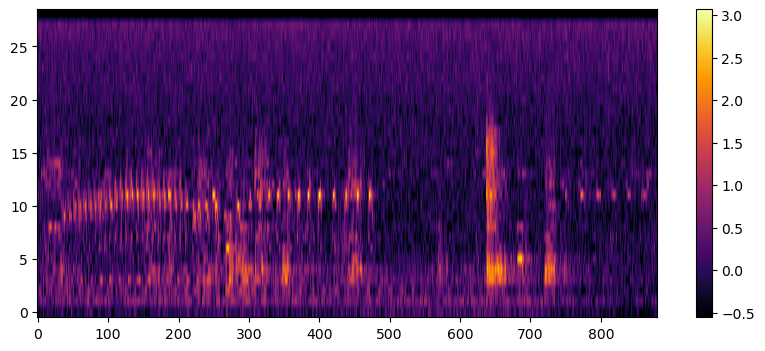

tensor(0)


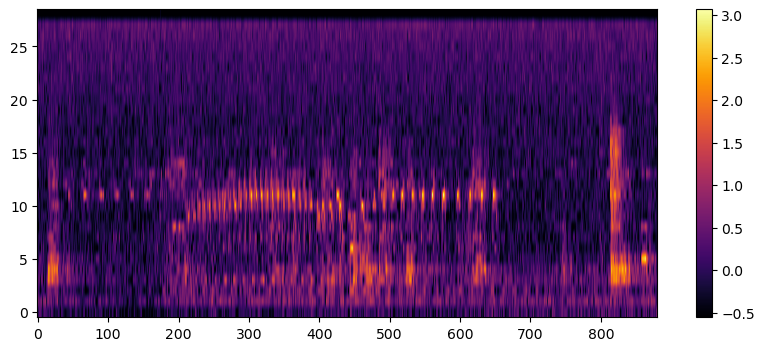

In [43]:
exampleplot = next(iter(train_loader))
plt.figure(figsize=(10, 4))
plt.imshow(exampleplot[0][0][0][0].numpy(), aspect='auto', origin='lower', cmap='inferno')
plt.colorbar()
plt.show()
plt.figure(figsize=(10, 4))
plt.imshow(exampleplot[0][1][0][0].numpy(), aspect='auto', origin='lower', cmap='inferno')
plt.colorbar()
print(exampleplot[1][0])

In [44]:
newthing = torch.cat(exampleplot[0])

In [45]:
exampleplot[0][0].shape

torch.Size([8, 1, 29, 881])

In [46]:
exampleplot[1].repeat(2)

tensor([0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1])

In [47]:
newthing.shape

torch.Size([32, 1, 29, 881])

In [48]:
class IDModel(nn.Module):
    def __init__(self):
        super().__init__()
        conv_layers = []

        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(16)
        conv_layers += [self.conv1, self.relu1, self.bn1]

        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(32)
        conv_layers += [self.conv2, self.relu2, self.bn2]

        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(64)
        conv_layers += [self.conv3, self.relu3, self.bn3]

        self.ap = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.lin1 = nn.Linear(64, 32)
        self.act1 = nn.ReLU()
        self.lin2 = nn.Linear(32, len(label_map))

        self.conv = nn.Sequential(*conv_layers)

    def forward(self, x):

        x = self.conv(x)
        x = self.ap(x)
        x = x.view(x.size(0), -1)
        x = self.lin1(x)
        x = self.act1(x)
        x = self.lin2(x)

        return x

In [49]:
augModel = IDModel()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
augModel = augModel.to(device)
# Check that it is on Cuda
next(augModel.parameters()).device

device(type='cuda', index=0)

In [50]:
def noaugtest(model, test_dl):
    correct_preds = 0
    total_preds = 0
    with torch.no_grad():
        for data in test_dl:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)
        
        acc = correct_preds / total_preds
        return acc

losslist = []
def noaugtraining(model, train_dl, numepochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=numepochs,
                                                anneal_strategy='linear')
    for epoch in range(numepochs):
        runningloss = 0.0
        correct_preds = 0
        total_preds = 0

        for i, data in enumerate(train_dl):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            runningloss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)
            print(f"Batch: {i}, Loss: {loss.item()}")
            noauglosslist.append(loss.item())
            
        
        num_batches = len(train_dl)
        avg_loss = runningloss / num_batches
        acc = correct_preds / total_preds
        test_acc = noaugtest(model, noaugtest_loader)
        noaugtraining_acc.append(acc)
        noaugtest_accs.append(test_acc)
        print(f"Epoch: {epoch}, Loss: {avg_loss}, Accuracy: {acc}, Test Accuracy: {test_acc}")
    
    print("Finished Training")

In [51]:
def augtest(model, test_dl):
    correct_preds = 0
    total_preds = 0
    with torch.no_grad():
        for data in test_dl:
            inputstuple, labels = data
            inputs = inputstuple[0]
            # put each element of inputstuple one after the other
            
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)
        
        acc = correct_preds / total_preds
        return acc

losslist = []
def augtraining(model, train_dl, numepochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=numepochs,
                                                anneal_strategy='linear')
    for epoch in range(numepochs):
        runningloss = 0.0
        correct_preds = 0
        total_preds = 0

        for i, data in enumerate(train_dl):
            inputstuple, labelshalf = data
            labels = labelshalf.repeat(len(inputstuple))
            inputs = torch.cat(inputstuple)
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            runningloss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)
            print(f"Batch: {i}, Loss: {loss.item()}")
            losslist.append(loss.item())
            
        
        num_batches = len(train_dl)
        avg_loss = runningloss / num_batches
        acc = correct_preds / total_preds
        test_acc = augtest(model, test_loader)
        training_acc.append(acc)
        test_accs.append(test_acc)
        print(f"Epoch: {epoch}, Loss: {avg_loss}, Accuracy: {acc}, Test Accuracy: {test_acc}")
    
    print("Finished Training")

In [52]:
train_df["label"].value_counts()

label
1    359
0    341
Name: count, dtype: int64

In [53]:
losslist = []
training_acc = []
test_accs = []
augtraining(augModel, train_loader, 75)

Batch: 0, Loss: 0.7072849273681641
Batch: 1, Loss: 0.7036544680595398
Batch: 2, Loss: 0.6782805919647217
Batch: 3, Loss: 0.6977455019950867
Batch: 4, Loss: 0.6929208636283875
Batch: 5, Loss: 0.6975376605987549
Batch: 6, Loss: 0.6956698894500732
Batch: 7, Loss: 0.7049506902694702
Batch: 8, Loss: 0.730013906955719
Batch: 9, Loss: 0.7079361081123352
Batch: 10, Loss: 0.6897664070129395
Batch: 11, Loss: 0.7103554606437683
Batch: 12, Loss: 0.7043752074241638
Batch: 13, Loss: 0.7059538960456848
Batch: 14, Loss: 0.7040212154388428
Batch: 15, Loss: 0.7054460048675537
Batch: 16, Loss: 0.7153098583221436
Batch: 17, Loss: 0.6874827146530151
Batch: 18, Loss: 0.6872403621673584
Batch: 19, Loss: 0.6756414771080017
Batch: 20, Loss: 0.6905703544616699
Batch: 21, Loss: 0.7193337082862854
Batch: 22, Loss: 0.6829281449317932
Batch: 23, Loss: 0.6810190081596375
Batch: 24, Loss: 0.6668976545333862
Batch: 25, Loss: 0.6933137774467468
Batch: 26, Loss: 0.6615157127380371
Batch: 27, Loss: 0.7045720815658569
Bat

c:\Users\Arnav\anaconda3\envs\torchenv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Arnav\anaconda3\envs\torchenv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: >

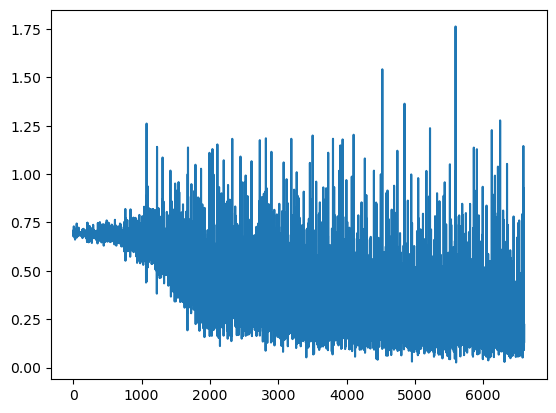

In [54]:
sns.lineplot(x=range(len(losslist)), y=losslist)

c:\Users\Arnav\anaconda3\envs\torchenv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Arnav\anaconda3\envs\torchenv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: >

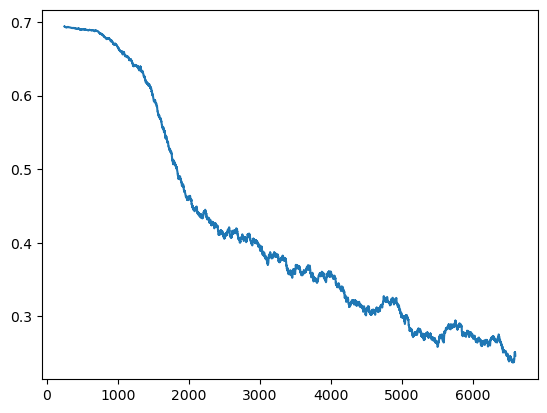

In [55]:
# rolling average
sns.lineplot(x=range(len(losslist)), y=pd.Series(losslist).rolling(250).mean())

c:\Users\Arnav\anaconda3\envs\torchenv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Arnav\anaconda3\envs\torchenv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Arnav\anaconda3\envs\torchenv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Arnav\anaconda3\envs\torchenv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

<Axes: >

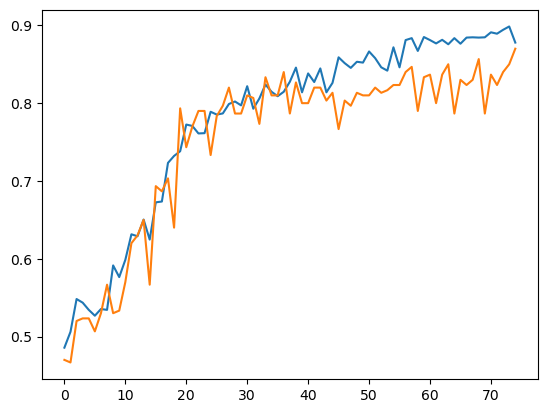

In [56]:
#plot both training and test accuracies
sns.lineplot(x=range(len(training_acc)), y=training_acc)
sns.lineplot(x=range(len(test_accs)), y=test_accs)


In [57]:
noaugmodel = IDModel()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
noaugmodel = noaugmodel.to(device)
# Check that it is on Cuda
next(noaugmodel.parameters()).device

device(type='cuda', index=0)

In [58]:
noauglosslist = []
noaugtraining_acc = []
noaugtest_accs = []
noaugtraining(noaugmodel, noaugtrain_loader, 75)

c:\Users\Arnav\anaconda3\envs\torchenv\lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Batch: 0, Loss: 0.7161990404129028
Batch: 1, Loss: 0.6690641045570374
Batch: 2, Loss: 0.6933196783065796
Batch: 3, Loss: 0.6891936659812927
Batch: 4, Loss: 0.7024116516113281
Batch: 5, Loss: 0.7178938984870911
Batch: 6, Loss: 0.7212000489234924
Batch: 7, Loss: 0.6225168108940125
Batch: 8, Loss: 0.7206771373748779
Batch: 9, Loss: 0.6560026407241821
Batch: 10, Loss: 0.7193124294281006
Batch: 11, Loss: 0.695429265499115
Batch: 12, Loss: 0.732448935508728
Batch: 13, Loss: 0.6992779970169067
Batch: 14, Loss: 0.6268343925476074
Batch: 15, Loss: 0.6313063502311707
Batch: 16, Loss: 0.6966915130615234
Batch: 17, Loss: 0.7335458993911743
Batch: 18, Loss: 0.6556167006492615
Batch: 19, Loss: 0.6836036443710327
Batch: 20, Loss: 0.706670880317688
Batch: 21, Loss: 0.7192764282226562
Batch: 22, Loss: 0.699255108833313
Batch: 23, Loss: 0.6969136595726013
Batch: 24, Loss: 0.7000935673713684
Batch: 25, Loss: 0.669890820980072
Batch: 26, Loss: 0.7328781485557556
Batch: 27, Loss: 0.73382568359375
Batch: 28

KeyboardInterrupt: 

c:\Users\Arnav\anaconda3\envs\torchenv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Arnav\anaconda3\envs\torchenv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Arnav\anaconda3\envs\torchenv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Arnav\anaconda3\envs\torchenv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

<Axes: >

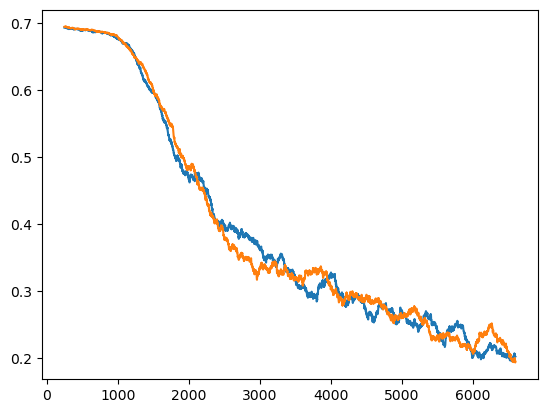

In [ ]:
sns.lineplot(x=range(len(noauglosslist)), y=pd.Series(noauglosslist).rolling(250).mean())
sns.lineplot(x=range(len(losslist)), y=pd.Series(losslist).rolling(250).mean())

c:\Users\Arnav\anaconda3\envs\torchenv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Arnav\anaconda3\envs\torchenv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Arnav\anaconda3\envs\torchenv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Arnav\anaconda3\envs\torchenv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

<Axes: >

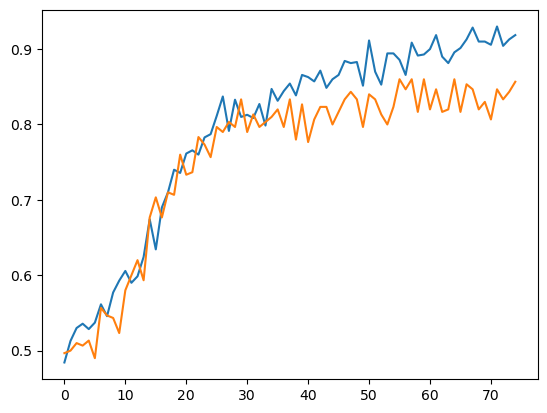

In [ ]:
sns.lineplot(x=range(len(noaugtraining_acc)), y=noaugtraining_acc)
sns.lineplot(x=range(len(noaugtest_accs)), y=noaugtest_accs)

In [ ]:
accuracy_df= pd.read_csv("accuracydf.csv")
loss_df = pd.read_csv("lossdf.csv")

In [71]:
accuracy_df

augmentedtest  noaugmentedtest  augmentedtrain  noaugmentedtrain  \
0        0.470000         0.496667        0.485714          0.484286   
1        0.466667         0.500000        0.506071          0.512857   
2        0.520000         0.510000        0.548214          0.530000   
3        0.523333         0.506667        0.543571          0.535714   
4        0.523333         0.513333        0.534286          0.528571   
..            ...              ...             ...               ...   
70       0.836667         0.806667        0.891071          0.905714   
71       0.823333         0.846667        0.889286          0.930000   
72       0.840000         0.833333        0.894286          0.904286   
73       0.850000         0.843333        0.898571          0.912857   
74       0.870000         0.856667        0.877857          0.918571   

     test_ts  train_ts  
0   0.530000  0.487143  
1   0.533333  0.492857  
2   0.516667  0.505714  
3   0.536667  0.496429  
4   0.540000  0.526429  
..       ...       ...  
70  0.846667  0.897857  
71  0.806667  0.915714  
72  0.846667  0.902857  
73  0.846667  0.938571  
74  0.816667  0.919286  

[75 rows x 6 columns]

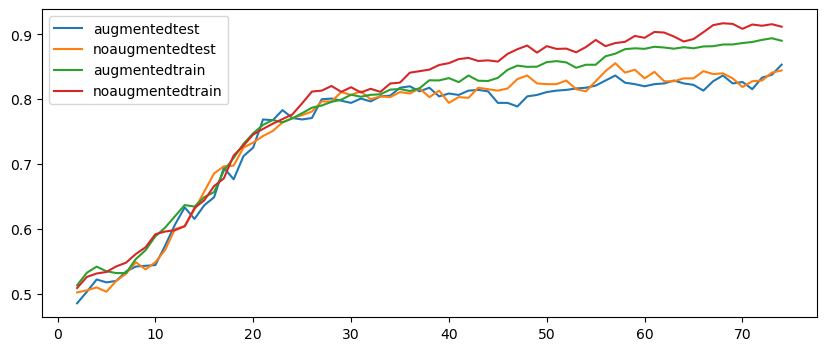

In [79]:
plt.figure(figsize=(10, 4))
plt.plot(range(len(accuracy_df)), accuracy_df['augmentedtest'].rolling(3).mean(), label='augmentedtest')
plt.plot(range(len(accuracy_df)), accuracy_df['noaugmentedtest'].rolling(3).mean(), label='noaugmentedtest')
# plt.plot(range(len(accuracy_df)), accuracy_df['test_ts'], label='Time_shift_test')
plt.plot(range(len(accuracy_df)), accuracy_df['augmentedtrain'].rolling(3).mean(), label='augmentedtrain')
plt.plot(range(len(accuracy_df)), accuracy_df['noaugmentedtrain'].rolling(3).mean(), label='noaugmentedtrain')
# plt.plot(range(len(accuracy_df)), accuracy_df['train_ts'], label='Time_shift_train')
plt.legend()

In [74]:
loss_df

augmented  noaugmented        ts
0      0.707285     0.686438  0.714773
1      0.703654     0.686676  0.673602
2      0.678281     0.689991  0.702000
3      0.697746     0.704160  0.701378
4      0.692921     0.684678  0.704822
...         ...          ...       ...
6595   0.091185     0.208475  0.135241
6596   0.095183     0.126596  0.243142
6597   0.139825     0.136024  0.072291
6598   0.225508     0.065324  0.043315
6599   0.133236     0.097860  0.484509

[6600 rows x 3 columns]

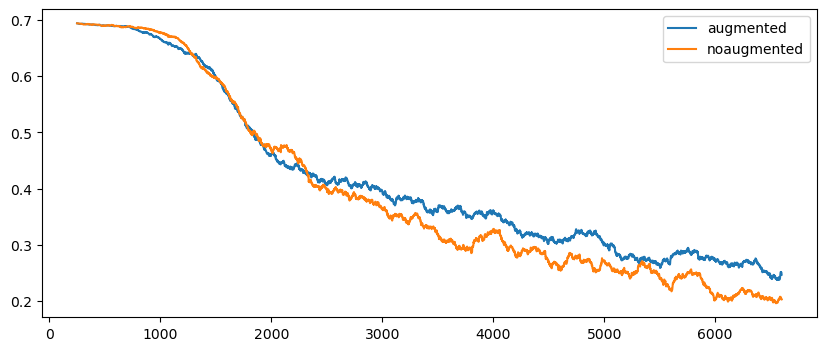

In [78]:
plt.figure(figsize=(10, 4))
plt.plot(range(len(loss_df)), loss_df['augmented'].rolling(250).mean(), label='augmented')
plt.plot(range(len(loss_df)), loss_df['noaugmented'].rolling(250).mean(), label='noaugmented')
#plt.plot(range(len(loss_df)), loss_df['ts'].rolling(250).mean(), label='Time_shift')
plt.legend()

In [67]:
# lossdf.to_csv('lossdf.csv', index=False)
# accuracy_df.to_csv('accuracydf.csv', index=False)